# **Bayesian Nonparametrics in Practice**

---

## What are Bayesian nonparametric models?
Bayesian nonparametric models are models where the number of parameters grow freely with the amount of data provided; thus, instead of training several models that vary in complexity and comparing them, one is able to design a model whose complexity grows as more data are observed. The prototypical example of Bayesian nonparametrics in practice is the *Dirichlet Process Mixture Model* (DPMM), which also serves as the focus of this project. A DPMM allows for a practitioner to build a mixture model when the number of distinct clusters in the geometric structure of their data is unknown – in other words, the number of clusters is allowed to grow as more data is observed. This is in contrast to the typical mixture model, in which the number of clusters is fixed, and inference must be done each time the practitioner wants to adjust this hyperparameter. This feature makes the DPMM highly useful towards exploratory data analysis, where few facets of the data in question are known; this presentation aims to demonstrate this fact. In particular, we will cover two formulations of the DPMM, three applications, and three distinct inference implementations. 

## The Dirichlet Process (Ferguson, 1973)
Dirichlet processes are a family of probability distributions over discrete probability distributions. Formally, the Dirichlet process (DP) is specified by some base probability distribution $G_0: \Omega \to \mathbb{R}$ and a positive, real, scaling parameter commonly denoted as $\alpha$. For any disjoint union $\Omega_1, ..., \Omega_k$ of $\Omega$, and any sample $G \sim DP(G_0, \alpha)$, we have:

$$(G(\Omega_1), ..., G(\Omega_k)) \sim \text{Dir}(\alpha G_0(\Omega_1), ..., \alpha G_0(\Omega_k))$$

[Essentially, what this is doing is taking a discretization of the domain $\Omega$ and then building a discrete distribution on top of it through a draw from a Dirichlet distribution that is dependent on $\alpha$ and $G_0$ in the above manner]

While quite abstract in formulation, the Dirichlet process is very useful as a prior in various graphical models. This fact becomes easier to see in the following scheme.

## The Chinese Restaurant Process (????, xxxx)

Imagine a restaurant with infinite tables (indexed by the positive integers) that accepts customers one at a time. The $n$th customer chooses their seat according to the following probabilities:

*   With probability $\frac{n_t}{\alpha + n - 1}$, sit at table $t$, where $n_t$ is the number of people at table $t$
*   With probability $\frac{\alpha}{\alpha + n - 1}$, sit at an empty table

If we associate to each table $t$ a draw from a base distribution $G_0$ and then associate probability mass $n_t$ to that draw, the resulting distribution over $\Omega$ is equivalent to a draw from a Dirichlet process $DP(G_0, \alpha)$. 

Furthermore, we can easily extend this to define the generative process of a nonparametric mixture model: every table $t$ that has at least one customer seated is associated with a set of cluster parameters $\theta_t$, which were themselves drawn from some base distribution $G_0$. For each new observation, first assign that observation to a table according to the above probabilities; then, that observation is drawn from the distribution parameterized by the cluster parameters for that table. If the observation was assigned to a new table, draw a new set of cluster parameters from $G_0$, and then draw the observation from the distribution parameterized by those cluster parameters.

While this formulation of a Dirichlet process mixture model is intuitive, it is also very difficult to perform inference on in a probabilistic programming framework. Note that although the 'customers' are exchangeable (meaning that the order they arrive in does not matter), they are not conditionally independent: the number of customers currently seated affects the distribution over the newly arrived customer. Performing inference through MCMC (using Pyro) on this model breaks down during latent variable enumeration, as the framework is attempting to marginalize discrete latent variables, which in this case are the Categorical distributions that describe the probabilities of picking a given table for a given 'customer' / observation. Similarly, during variational inference, each variational Categorical factor in the variational family needs to be able to vary in cardinality throughout the optimization process, which is impossible to handle in Pyro. [give example here of three tables, then five, then four, etc]

This motivates an alternative formulation of DPMMs, which has empirically been shown to be more conducive to inference (e.g. Blei and Jordan, 2004).

## The Stick-Breaking Method (Sethuraman, xxxx)

The generative process for the stick-breaking formulation of DPMMs proceeds as follows:

* Draw $\beta_i \sim \text{Beta}(1, \alpha)$ for $i \in \mathbb{N}$
* Draw $\theta_i \sim G_0$ for $i \in \mathbb{N}$
* Construct the mixture weights $\pi$ by taking $\pi_i(\beta_{1:\infty}) = \beta_i \prod_{j<i} (1-\beta_j)$

* For each observation $n \in \{1, ..., N\}$, draw $z_n \sim \pi(\beta_{1:\infty})$, and then draw $x_n \sim f(\theta_{z_n})$

[Insert image of Blei graphical model picture here]

Here, the infinite nature of the Dirichlet process mixture model can more easily be seen. Furthermore, all $\beta_i$ are independent, so it is far easier to perform inference in a probabilistic programming framework. Note that during inference, one must define some truncation parameter $T$ of the maximum number of clusters they think could possibly exist in the data, since it would be impossible to infer the distribution of infinitely many $\beta_i$ and $\theta_i$ variables.


In [0]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

!pip install pyro-ppl
from pyro.distributions import *
import pyro
from pyro.infer.autoguide import *
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TracePredictive, EmpiricalMarginal
from torch.distributions import constraints
from pyro import poutine


# **Inference**

## Synthetic Mixture of Gaussians

We begin by demonstrating the capabilities of Dirichlet process mixture models on a synthetic dataset generated by a mixture of Gaussians:

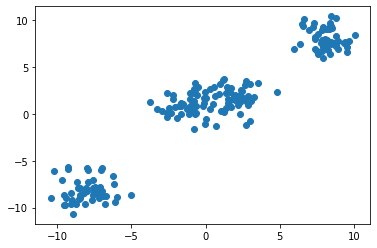

In [24]:
data = torch.cat((MultivariateNormal(-8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([2., 2]), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([-1., 1]), torch.eye(2)).sample([50])))

plt.scatter(data[:, 0], data[:, 1])
plt.show()
N = data.shape[0]

In this example, the cluster parameters $\theta_i$ are two dimensional vectors describing the means of a multivariate Gaussian with identity covariance. Therefore, the Dirichlet process base distribution $G_0$ is also a multivariate Gaussian (i.e. the conjugate prior), although this choice is not as computationally useful, since we are not performing coordinate-ascent variational inference but rather black box variational inference using Pyro. 

The plots below demonstrate the effects of the scaling hyperparameter $\alpha$. A greater $\alpha$ yields a more heavy-tailed distribution of the weights, whereas smaller $\alpha$ will place more mass on fewer clusters. In particular, the middle cluster looks like it could be generated a single Gaussian (although in fact it was generated by two distinct Gaussians), and thus the setting of $\alpha$ allows the practitioner to further encode their prior beliefs about how many clusters the data contains.

In [0]:
def mix_weights(beta): 
    weights = torch.zeros(beta.shape[0] + 1)
    for t in range(beta.shape[0]):
      weights[t] = beta[t] * torch.prod(1. - beta[:t], dim=0)
    weights[beta.shape[0]] = 1. - torch.sum(weights)
    return weights

def model(data):
    with pyro.plate("beta_plate", T-1):
      beta = pyro.sample("beta", dist.Beta(1, alpha))

    with pyro.plate("mu_plate", T):
      mu = pyro.sample("mu", dist.MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)))

    with pyro.plate("data", N):
      z = pyro.sample("z", dist.Categorical(mix_weights(beta)))
      pyro.sample("obs", dist.MultivariateNormal(mu[z], torch.eye(2)), obs=data)

def guide(data):
    kappa = pyro.param('kappa', dist.Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', dist.MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)).sample([T]))
    phi = pyro.param('phi', dist.Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
      q_beta = pyro.sample("beta", dist.Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
      q_mu = pyro.sample("mu", dist.MultivariateNormal(tau, torch.eye(2)))

    with pyro.plate("data", N):
      z = pyro.sample("z", dist.Categorical(phi))
    
T = 6
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=100)

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss))

def truncate(threshold, centers, weights):
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

alpha = 0.05
train(5000)
print (torch.mean(pyro.param("phi").detach(), dim=0))
Bayes_Centers_05, Bayes_Weights_05 = truncate(0.1, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

alpha = 1.5
train(5000)
print (torch.mean(pyro.param("phi").detach(), dim=0))
Bayes_Centers_15, Bayes_Weights_15 = truncate(0.1, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_05[:, 0], Bayes_Centers_05[:, 1], color="red")

plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_15[:, 0], Bayes_Centers_15[:, 1], color="red")
plt.show()
plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/pyro/infer/svi.py:50: FutureWarning: The `num_samples` argument to SVI is deprecated and will be removed in a future release. Use `pyro.infer.Predictive` class to draw samples from the posterior.
  'samples from the posterior.', FutureWarning)


[iteration 0001] loss: 9100.4885
[iteration 0501] loss: 3462.2727
[iteration 1001] loss: 2324.7057
[iteration 1501] loss: 2362.8983
[iteration 2001] loss: 1840.5753
[iteration 2501] loss: 1838.6288
[iteration 3001] loss: 1527.0867
[iteration 3501] loss: 1495.5430
[iteration 4001] loss: 1464.6557
[iteration 4501] loss: 1525.5149

tensor([0.2290, 0.0471, 0.1064, 0.2442, 0.1701, 0.2031])


[iteration 0001] loss: 8654.9186


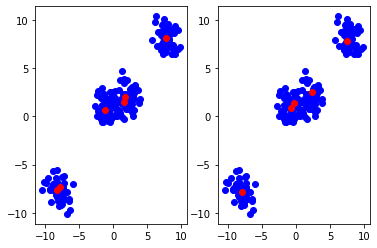

<Figure size 432x288 with 0 Axes>

In [19]:
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_05[:, 0], Bayes_Centers_05[:, 1], color="red")

plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_15[:, 0], Bayes_Centers_15[:, 1], color="red")
plt.show()

plt.tight_layout()

## Dirichlet Mixture Model for Long Term Solar Observations 

As mentioned earlier, the Dirichlet process mixture model truly shines when exploring a dataset whose latent geometric structure is completely unknown. To demonstrate this, we fit a DPMM on sunspot count data taken over the past 300 years (provided by the Royal Observatory of Belgium):

(As Blei and Jordan note in their 2004 paper 'blah blah blah', the truncation is occurring at the inference step and not the modeling step, the model is still an infinite mixtur emodel) Cover the differences between GMM, prior == Dirichlet process so weights will be assigned more heavily on things that have already been seen


[Note that the MAP inference done for MNIST is through explicit CAVI updates]

[Plot log joint]

[Autocorrelations of log joint (see FGM hw1 for code)] 